# Assessing Landscape Fragmentation with the CLCplus Backbone Dataset

**Description**

This notebook demonstrates how to use the latest CLCplus Backbone 2023 dataset to calculate spatial metrics that quantify landscape fragmentation. 
It guides you through the process of selecting Areas of Interest (AOIs) and computing key indicators such as: 

Boundary Length: The total length of boundaries between land cover classes within an AOI 

Edge Density: The ratio of total edge length to area, indicating the degree of fragmentation or heterogeneity within the landscape 

The notebook also enables you to compute these metrics between specific land cover classes to analyse fragmentation patterns across selected landscape types. 
 

**Workflow Overview**

The workflow integrates: 

Geospatial data processing 

Raster analysis 

Statistical computation 

Together, these components provide both quantitative metrics and visual insights into the spatial structure of the landscape. 
 

**Objective**

To use the CLCplus Backbone 2023 dataset to assess the degree of landscape fragmentation and to better understand landscape composition within selected AOIs. 

## 1. Introduction

Landscape fragmentation is a fundamental process that shapes both natural ecosystems and human-modified environments. It refers to the division of continuous land cover into smaller, often isolated patches, typically caused by land-use changes such as urban expansion, infrastructure development, or agricultural intensification. While fragmentation can disrupt ecological connectivity and diminish habitat quality, it also provides insights into broader patterns of spatial organisation, land management, and territorial planning. 

Understanding the structure and extent of landscape fragmentation is essential not only for assessing habitat integrity and biodiversity but also for supporting sustainable spatial development.  

- High Land Fragmentation: Highly fragmented areas often indicate zones of competing land uses, urban sprawl, or inefficient landscape configurations, all of which have important implications for planning, infrastructure development, and resource management.  

- Low Land Fragmentation: Conversely, landscapes with low fragmentation typically exhibit greater ecological coherence and can better support efficient land-use planning and the design of green infrastructure. 

In this notebook, we use the CLCplus Backbone 2023 dataset to analyse landscape fragmentation within selected AOIs. By computing spatial metrics such as boundary length and edge density, you can quantify the degree of fragmentation and examine transitions between different land cover classes. These metrics offer valuable insights into both ecological patterns and human-induced landscape dynamics, supporting evidence-based decision-making in environmental monitoring, spatial planning, and sustainable land management. 

Let’s begin by first installing the necessary packages. 

Click on the cell below containing the Python code to begin the installation. Once selected, start the process by clicking the “Run” (▶) button in the toolbar at the top of the page. The installation may take a few moments to complete. 

As you progress through the notebook, you’ll need to interact with each Python cell in the same way, selecting the cell and clicking “Run” to execute the code. 

In [1]:
packages = ['rasterio', 'folium', 'numpy', 'matplotlib', 'pandas', 
           'seaborn', 'branca', 'Pillow', 'ipywidgets', 'geopandas']

for package in packages:
    !pip install -q {package}
    print(f"{package} installed")

print("Done.")

rasterio installed
folium installed
numpy installed
matplotlib installed
pandas installed
seaborn installed
branca installed
Pillow installed
ipywidgets installed
geopandas installed
Done.


Now that our packages are installed, we can import the required libraries. Most of the functions used in this notebook are custom-defined and located in the modules/ directory. In addition, we define below a set of constant variables that will be used throughout the notebook.  

In [1]:
from modules.regions_dict import regions_dict
from modules.analysis import (calculate_class_areas,
                            print_class_areas,
                            get_boundary_length,
                            get_boundary_length_per_class_pair
                            )
from modules.utils import (choose_region,
                           visualize_class_pair_boundaries,
                           plot_dual_histograms,
                           display_park_info,
                           CLC_CLASS_INFO)
from modules.maps import display_map_discrete, overlay_region_boundary

from IPython.display import Image, display

# path to area-of-interest rasters directory
rasters_dir = 'aoi_rasters/'
buffers_dir = 'aoi_rasters/buffer_only/'
buffered_dir = 'aoi_rasters/buffered_1km/'

### CLCplus Backbone 2023

Land cover data describes the physical and biological characteristics of the Earth’s surface, including forests, agricultural areas, urban zones, water bodies, and wetlands. These datasets provide a spatially explicit view of how land is used and transformed over time, making them fundamental for understanding environmental patterns, ecological processes, and human impacts on the landscape. High-quality land cover data is essential for analysing spatial structure, monitoring change, and supporting sustainable land management and policy decisions. 

The applications and importance of land cover data span multiple domains. In environmental science, they support biodiversity assessments, habitat mapping, and ecological modelling. In land-use planning and resource management, they provide an objective basis for evaluating development patterns and identifying areas of ecological significance or risk. For climate and sustainability research, they serve as vital inputs to models that quantify carbon fluxes, monitor deforestation, and assess land degradation. 

The CLCplus Backbone 2023 dataset, produced by the Copernicus Land Monitoring Service (CLMS), underpins the exercises in this notebook. It offers a high-resolution (10 m) representation of land cover across Europe, covering the EEA38 countries and the United Kingdom. Each pixel represents the dominant land cover type, classified into 11 standardised categories, reflecting conditions for the reference year 2023. 

### Selecting the area for analysis

In this notebook, we explore landscape composition and fragmentation using national parks in Poland as an example. To begin, the cell below displays the CLCplus Backbone land cover map for Poland, showing the locations of its 23 national parks. 
 

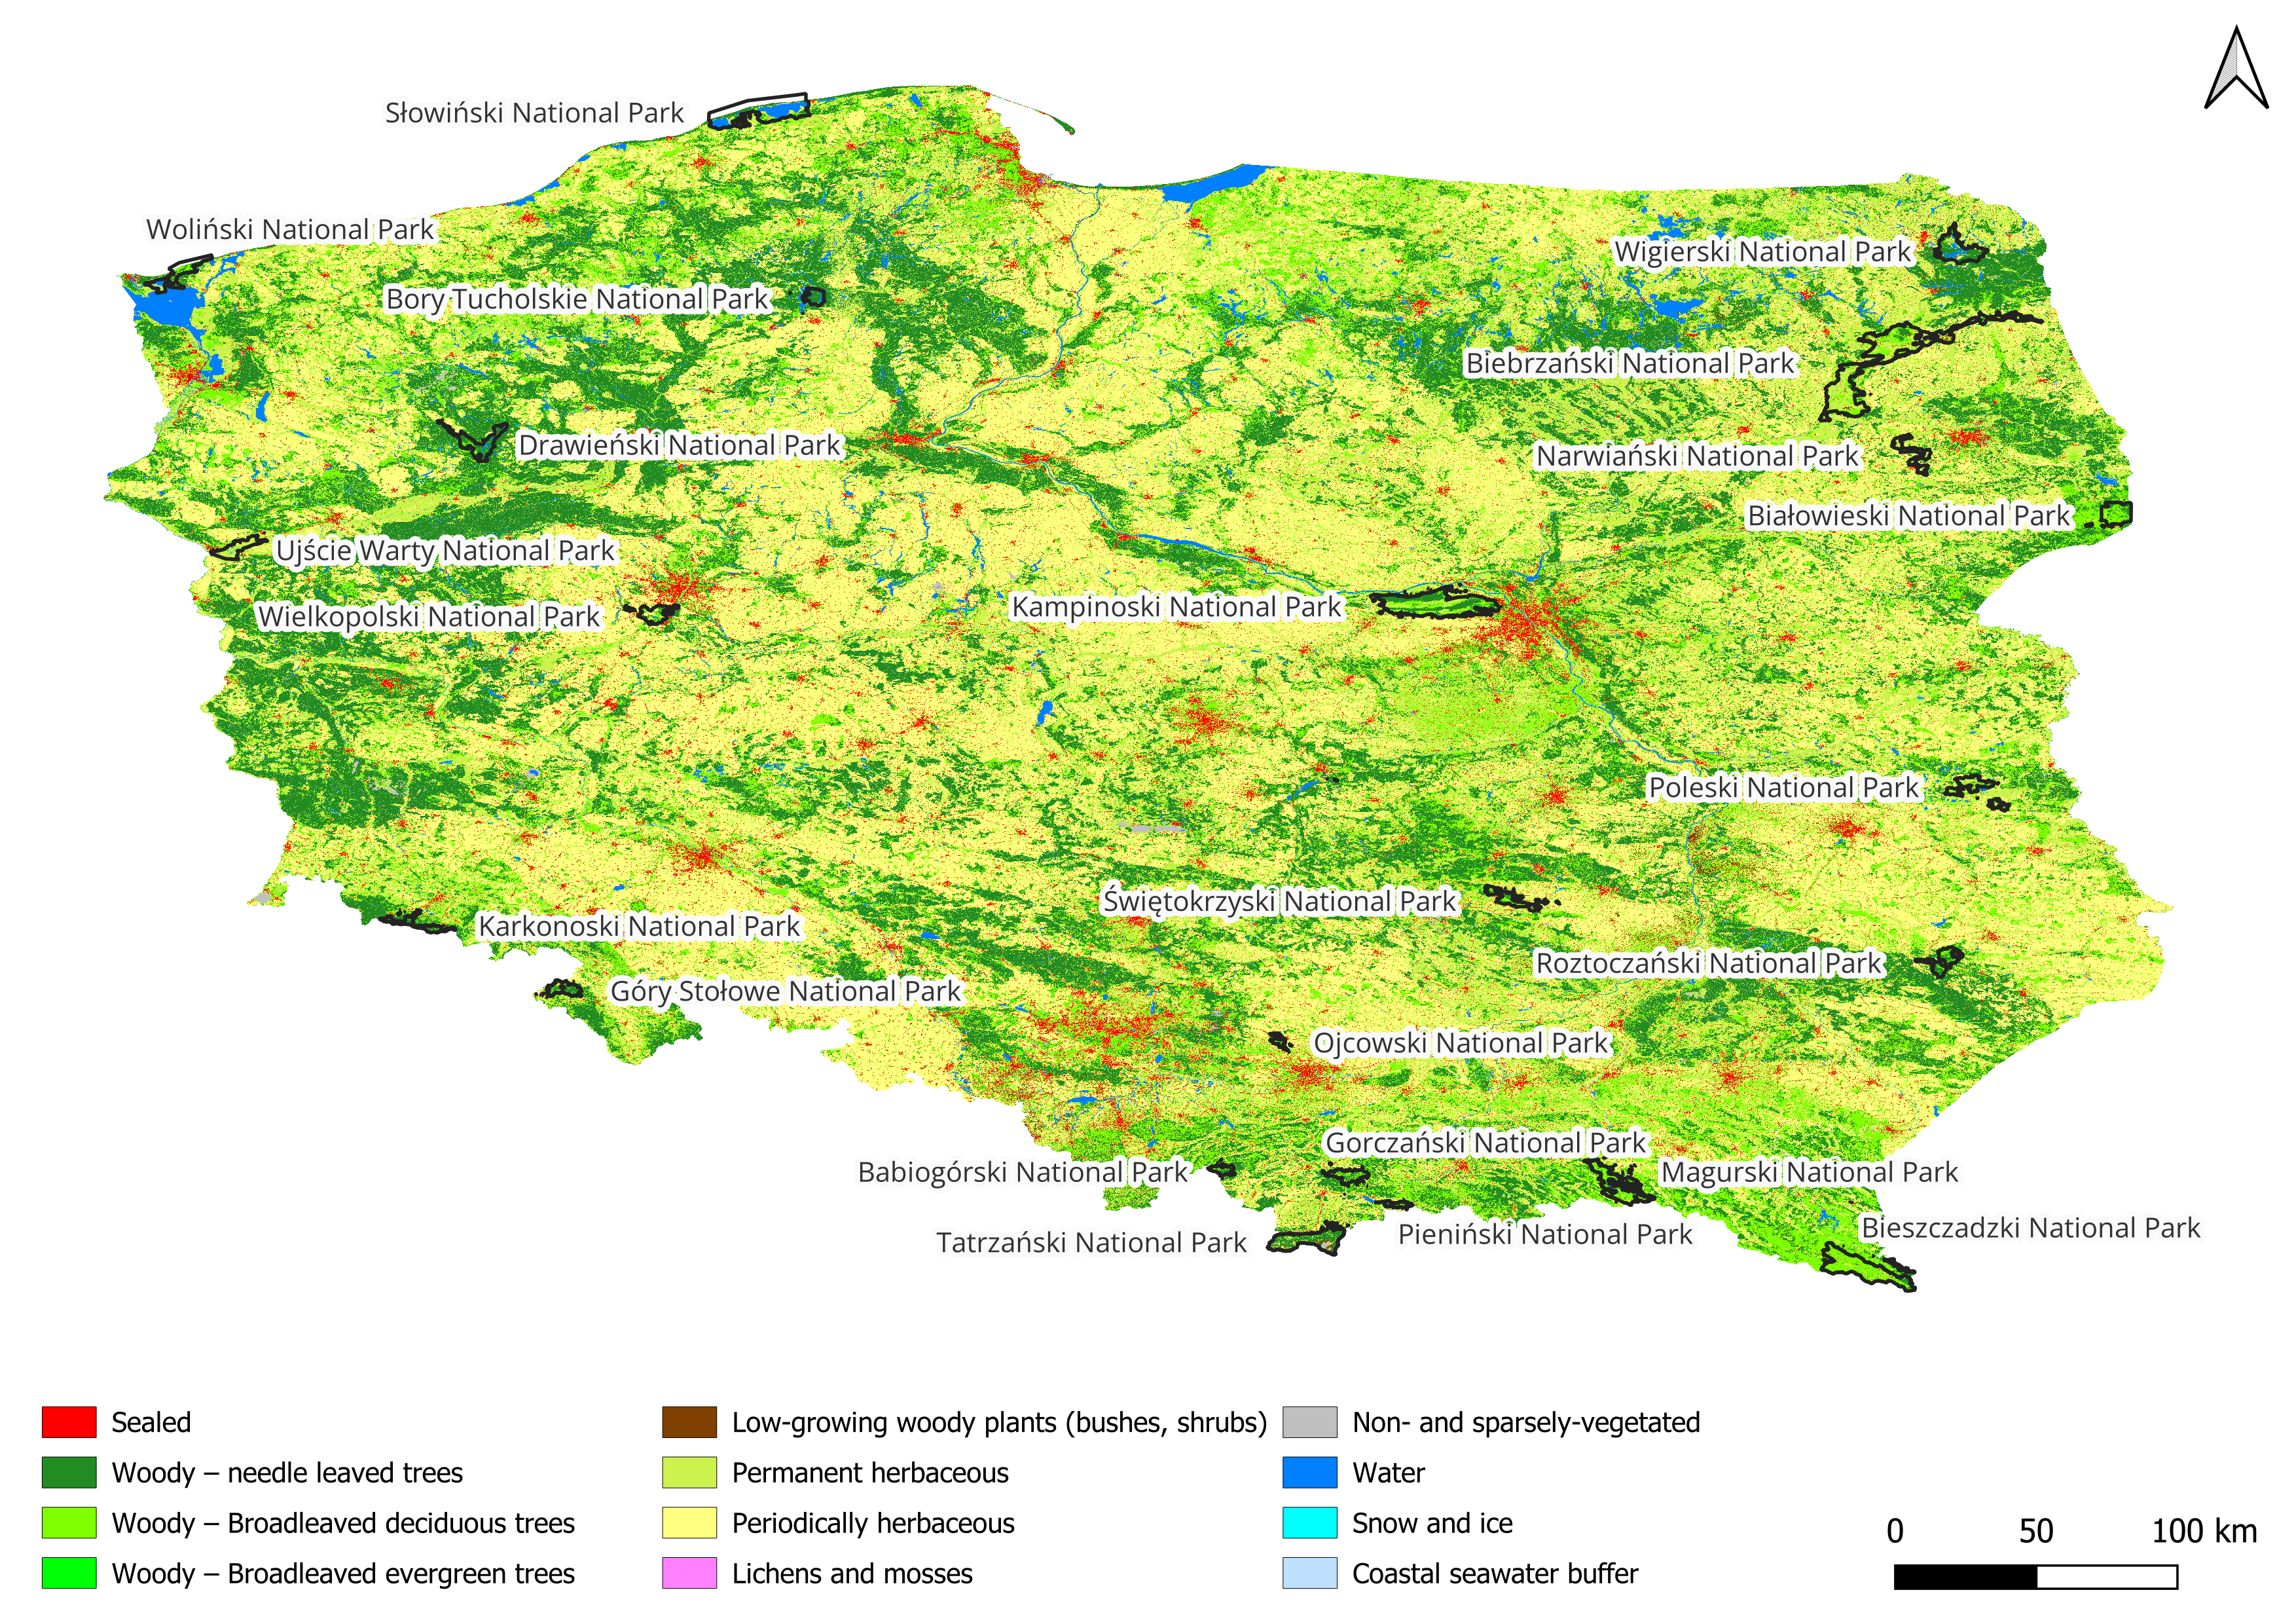

In [2]:
# Display the Poland national parks PNG image
png_file = 'images/Poland_National_Park_Location_Map.png'
display(Image(png_file, width=1000))

In the following section, we will focus on a specific national park in Poland to explore the spatial detail of the 10-metre resolution CLCplus Backbone land cover dataset. The variable regions_dict, imported from modules/regions_dict.py, contains information on all the national parks available for analysis in this notebook. 

Let’s display the full list of available parks stored in regions_dict: 

In [3]:
print(f'Areas available for analysis:')
for i, region in enumerate(regions_dict.keys()):
    print(f'    {i+1}. {region}')

Areas available for analysis:
    1. Babiogorski National Park
    2. Bialowieski National Park
    3. Biebrzanski National Park
    4. Bieszczadzki National Park
    5. Bory Tucholskie National Park
    6. Drawienski National Park
    7. Gorczanski National Park
    8. Gory Stolowe National Park
    9. Kampinoski National Park
    10. Karkonoski National Park
    11. Magurski National Park
    12. Narwianski National Park
    13. Ojcowski National Park
    14. Pieninski National Park
    15. Poleski National Park
    16. Roztoczanski National Park
    17. Slowinski National Park
    18. Swietokrzyski National Park
    19. Tatrzanski National Park
    20. Ujscie Warty National Park
    21. Wielkopolski National Park
    22. Wigierski National Park
    23. Wolinski National Park


Please select one of the national parks from the dropdown menu below: 

In [4]:
# Create dropdown widget and display it; value will update on user interaction
region_dropdown = choose_region(regions_dict)

Dropdown(description='Region:', options=('Babiogorski National Park', 'Bialowieski National Park', 'Biebrzansk…

In [8]:
# Use the current selected region from the dropdown widget
chosen_region = region_dropdown.value

# Display park info panel using utility function
display_park_info(chosen_region)

## 2. Visualization of CLCplus Backbone dataset for the selected National Park

In this section, we visualise the CLCplus Backbone 2023 land cover dataset for the national park selected from the dropdown menu above. To enable efficient data handling, the dataset used in this notebook has been preprocessed. Each national park has been cropped from the CLCplus Backbone dataset and saved as an individual raster file in the aoi_rasters/ directory. 

The cell below generates an interactive map using the display_map_discrete() function from the module module/maps.py. This map overlays the CLCplus Backbone land cover classes onto an OpenStreetMap basemap, allowing you to visually explore the land cover composition within the selected national park. 

In [ ]:
# Using display_map_discrete for categorical/discrete land cover data
base_map = 'OpenStreetMap'

clc_discrete_setup = {'label': "CLCplusBB", 'layer_name': "Land Cover Classes", 'opacity': 0.8}

# display_map_discrete is specifically designed for discrete/categorical data
map_object = display_map_discrete(buffered_dir, chosen_region, base_map, 
                    clc_discrete_setup, 
                    class_info=CLC_CLASS_INFO,
                    map_size=(800, 600),
                    target_projection='4326'
)

# Derive slug (replace spaces with underscores)
region_slug = chosen_region.replace(" ", "_")

# Overlay the National Park boundary
map_object = overlay_region_boundary(map_object, region_slug, vectors_dir='aoi_vectors/')

# Display the map
map_object

## 3. Calculating layer statistics

In Section 2, we visualised the land cover map of our selected national park and explored its characteristics and patterns. In this section, we focus on summarising and analysing the data using statistical metrics and visualisations with functions imported from modules/analysis.py. 

Let’s begin by calculating the total area (in hectares) of the national park, along with the area and proportion of each land cover class: 

In [7]:
# Calculate area statistics with the fixed function
area_results = calculate_class_areas(
    rasters_dir=rasters_dir,
    chosen_region=chosen_region,
    dataset_label='CLCplusBB',
    target_projection='3035',
    class_info=CLC_CLASS_INFO
)

# Print formatted results
print_class_areas(area_results, header= f"{chosen_region}")

Area Statistics
---------------
Region: Swietokrzyski National Park
Total area: 7694.20 ha

Class ID Class Name                                    Area (ha)    Area (%)  
----------------------------------------------------------------------
2        Woody-needle leaved trees                     3786.05      49.2      
3        Woody-Broadleaved deciduous trees             3745.05      48.7      
6        Permanent herbaceous                          143.65       1.9       
1        Sealed                                        11.24        0.1       
7        Periodically herbaceous                       3.41         0.0       
5        Low-growing woody plants (bushes, shrubs)     2.77         0.0       
9        Non- and sparsely-vegetated                   1.68         0.0       
10       Water                                         0.35         0.0       
----------------------------------------------------------------------
Total                                                  

In [8]:
# Calculate area statistics for buffer area
buffer_area_results = calculate_class_areas(
    rasters_dir=buffers_dir,
    chosen_region=chosen_region,
    dataset_label='CLCplusBB',
    target_projection='3035',
    class_info=CLC_CLASS_INFO
)

# Print formatted results for buffer area
print_class_areas(buffer_area_results, header= f"{chosen_region} Buffer Zone (1km)")

Area Statistics
---------------
Region: Swietokrzyski National Park Buffer Zone (1km)
Total area: 11295.93 ha

Class ID Class Name                                    Area (ha)    Area (%)  
----------------------------------------------------------------------
6        Permanent herbaceous                          4974.07      44.0      
7        Periodically herbaceous                       3025.27      26.8      
3        Woody-Broadleaved deciduous trees             1982.13      17.5      
2        Woody-needle leaved trees                     661.25       5.9       
1        Sealed                                        484.19       4.3       
9        Non- and sparsely-vegetated                   76.81        0.7       
5        Low-growing woody plants (bushes, shrubs)     75.98        0.7       
10       Water                                         16.23        0.1       
----------------------------------------------------------------------
Total                               

After calculating the area and percentage of each land cover class, we can visualise their distribution using a histogram. Only the classes present within the park are included. 

In [9]:
# Create dual histogram comparing park area vs buffer area
plot_dual_histograms(
    rasters_dir1='aoi_rasters/',           # Original park area
    rasters_dir2='aoi_rasters/buffer_only/', # Buffer area only
    chosen_region=chosen_region,
    dataset_label='CLCplusBB',
    title1=f"{chosen_region} - Park Area",
    title2=f"{chosen_region} - Buffer Zone (1km)",
    figure_size=(12, 6)
)

Landscapes can exhibit different levels of complexity even when they share the same class composition. In the example below, both areas have an identical composition — the number of pixels belonging to each land cover class is the same. However, their spatial configurations differ. In the left image, the forest occurs in two large, contiguous patches, whereas in the right image, the forest is fragmented into several smaller patches.

![Landscape complexity example illustrating identical composition with different spatial configuration](images/Landscape_complexity_labelled.png)

*Figure: Two synthetic landscapes with identical class counts but contrasting spatial arrangement. Left: low fragmentation (few large patches). Right: high fragmentation (many small patches).*

**Boundary Length** 

Boundary length refers to the total length of all edges or borders between different land cover classes within a defined area. It is typically measured in metres or kilometres and represents the extent of contact between distinct spatial units. 

This metric provides insight into the structural complexity and spatial configuration of a landscape. A longer total boundary length generally indicates a more heterogeneous or fragmented pattern, where multiple classes meet or transition frequently. Conversely, a shorter boundary length suggests a more homogeneous and continuous spatial structure. 

Boundary length is a versatile measure applied in both ecological and urban studies. In ecological contexts, it can describe habitat fragmentation or connectivity, while in urban or land use analyses it can characterise spatial mixing, zoning complexity, or development patterns.  

![Landscape with identical class composition and different fragmentation, black lines show boundaries](images/Boundary_length_types_titled.png)

*Figure: The total boundary length is indicated by black lines outlining the boundaries of all land cover classes. The more fragmented landscape on the right shows a longer total boundary length resulting from numerous smaller patches. The outside boundary of a study area is usually not included in boundary length calculations because it is an artificial edge imposed by the map extent, not a true boundary. Only boundaries between internal areas are counted.*

In [10]:
# Calculate total boundary length and edge density for the selected park
boundary_length, edge_density = get_boundary_length(
    rasters_dir=rasters_dir,
    chosen_region=region_slug,            # accepts human-readable name or slug
    dataset_label='CLCplusBB',
    target_projection='3035',
    input_nodata=254,                     # nodata value used in the AOI rasters
    class_info=CLC_CLASS_INFO
)
print(f"{chosen_region}:")
print("-"*35)
print(f"Total boundary length: {boundary_length:,.2f} km")
print(f"Edge density: {edge_density:,.2f} m per hectare")

Swietokrzyski National Park:
-----------------------------------
Total boundary length: 931.29 km
Edge density: 121.04 m per hectare


In [12]:
# Calculate total boundary length and edge density for the selected park
boundary_length, edge_density = get_boundary_length(
    rasters_dir=buffers_dir,
    chosen_region=region_slug,            # accepts human-readable name or slug
    dataset_label='CLCplusBB',
    target_projection='3035',
    input_nodata=254,                     # nodata value used in the AOI rasters
    class_info=CLC_CLASS_INFO
)
print(f"{chosen_region} Buffer Zone (1 km):")
print("-"*35)
print(f"Total boundary length: {boundary_length:,.2f} km")
print(f"Edge density: {edge_density:,.2f} m per hectare")

Swietokrzyski National Park Buffer Zone (1 km):
-----------------------------------
Total boundary length: 3,242.34 km
Edge density: 287.04 m per hectare


**Edge Density**

Edge density is a metric derived from boundary length that describes the amount of edge relative to the size of a landscape. It provides a standardised way to quantify spatial complexity and fragmentation, allowing meaningful comparisons between different landscapes or land cover types. 

Higher edge density values indicate a landscape with more boundaries and greater heterogeneity, while lower values reflect a simpler, more continuous spatial structure. 

Having computed the boundary length and edge density for the entire park, we can now calculate these metrics for each individual land cover class. To better understand how different classes interact spatially, we will visualise the results using a matrix format similar to a confusion matrix. 

In this matrix, each row and column represents a land cover class, and the values at the intersections indicate the boundary length or edge density between the corresponding classes. This allows us to identify which classes share the most boundaries and how strongly they are spatially connected. For example, a high value between forest and grassland indicates that these classes frequently meet along their edges, whereas a low value suggests they rarely occur adjacent to each other. 

In [14]:
# Get boundary length per class pair for the confusion matrix visualization
boundary_results = get_boundary_length_per_class_pair(
    rasters_dir=rasters_dir,
    chosen_region=region_slug,
    dataset_label='CLCplusBB',
    target_projection='3035',
    input_nodata=254,
    class_info=CLC_CLASS_INFO
    )

# Visualize class pair boundaries as a confusion matrix (length + density)
visualize_class_pair_boundaries(
    boundary_results,
    class_info=CLC_CLASS_INFO,
    use_names=True,
    metric='both',
    figsize=(12, 10))

Visual Summary of Landscape Fragmentation (?) 

Additional visualisation of final results 

 

Interpretation and Implications 

The results from the fragmentation analysis, combining boundary length and edge density, reveal the spatial complexity and connectivity of the selected national park. 
 
Together, these two metrics provide complementary perspectives on landscape structure: 

Boundary length… 

Edge Density… 

 

Interpreting the Results: 

Areas with high boundary length and high edge density represent highly fragmented zones. These are often transition areas between forests, grasslands, or agricultural land, or locations where human activity has modified natural patterns 

Moderate values may reflect naturally diverse mosaics, such as mixed woodland or wetland edges, where heterogeneity supports biodiversity 

Low boundary length and low edge density indicate large, continuous patches, typical of core habitat areas or regions with consistent land use and limited disturbance 

 

Implications for Landscape Management and Research: 

Ecological Connectivity: By highlighting where boundaries are concentrated, these metrics help identify potential barriers or corridors for species movement, supporting habitat connectivity assessments. 

Spatial Planning: Understanding the degree and type of fragmentation can guide land-use decisions, for example, where to reinforce green infrastructure or restrict new development. 

Monitoring and Policy Support: Repeating this analysis over time or across multiple regions can reveal trends in fragmentation, providing data-driven input for regional planning, conservation policy, and sustainable land management. 

 

Summary and Key Insights 

This notebook demonstrated how the CLCplus Backbone 2023 dataset can be used to assess landscape fragmentation within selected AoIs. 
Through geospatial data processing, raster analysis, and statistical computation, we: 

Quantified boundary length and edge density to describe spatial structure and fragmentation 

Visualised class-level interactions through matrices and comparative plots 

Interpreted results to understand both ecological coherence and anthropogenic landscape modification 

Together, these steps illustrate a practical workflow for transforming high-resolution land cover data into actionable spatial insights. 
 
The methods showcased here can be adapted to any region covered by the CLCplus Backbone dataset, providing a foundation for further research, monitoring, and sustainable landscape management.		 